# Project for People's Daily - Part #[5.2]
## Aligned Dynamic Word2Vec

In [1]:
import dask
import copy
import numpy as np
import pandas as pd
import seaborn
import gensim
import dask
from gensim.models.word2vec import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
import matplotlib as mpl
# matplotlib.rcParams[u'font.sans-serif'] = ['Heiti TC'] + matplotlib.rcParams[u'font.sans-serif']

In [2]:
dask.config.set(scheduler='threads')

# from dask.distributed import Client
# client = Client()
# client

In [3]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.vectors / np.sqrt((model.wv.vectors ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words 
    (see `intersection_align_gensim` documentation).
    """
    
    base_embed.init_sims()
    other_embed.init_sims()
#     base_embed = copy.copy(base_embed)
#     other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.vectors_norm = other_embed.wv.vectors = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors_norm = m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

@dask.delayed        
def alignModel_year(catOuter, cats): 
    embeddings_raw = {}
    for year in cats: 
        embeddings_raw[year] = Word2Vec.load(f'../models/Word2Vec&Doc2Vec/filtered_corpus/rmrb_{year}_W2V')
    embeddings_aligned_year = [embeddings_raw[catOuter]]
    for catInner in cats: 
        embeddings_aligned_year.append(
            smart_procrustes_align_gensim(
                embeddings_aligned_year[-1], 
                embeddings_raw[catInner]
            )
        )
    return (
        embeddings_aligned_year, 
        f'{catOuter} completed Procrustes aligning. '
    )


def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - cosine_similarity(
                np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                np.expand_dims(embed.wv[word], axis = 0)
            )[0,0]))
    return pd.DataFrame(dists, index=cats)

In [4]:
cats = [year for year in range(1965, 2003)]

# cats = [year for year in range(1969, 1989)]
# cats = [year for year in range(1989, 2004)]

In [5]:
%%time
embeddings_aligned = {}
for a in range(7): 
    delayed_funcs = []
    for catOuter in cats[a * 5: (a + 1) * 5]: 
        delayed_funcs.append(alignModel_year(catOuter, cats))
    for ind, response in enumerate(dask.compute(*delayed_funcs)): 
        embeddings_aligned[cats[a * 5: (a + 1) * 5][ind]] = response[0]
        print(response[1])
delayed_funcs = []
for catOuter in cats[35:]:
    delayed_funcs.append(alignModel_year(catOuter, cats))
for ind, response in enumerate(dask.compute(*delayed_funcs)): 
    embeddings_aligned[cats[35:][ind]] = response[0]
    print(response[1])

1965 completed Procrustes aligning. 
1966 completed Procrustes aligning. 
1967 completed Procrustes aligning. 
1968 completed Procrustes aligning. 
1969 completed Procrustes aligning. 
1970 completed Procrustes aligning. 
1971 completed Procrustes aligning. 
1972 completed Procrustes aligning. 
1973 completed Procrustes aligning. 
1974 completed Procrustes aligning. 
1975 completed Procrustes aligning. 
1976 completed Procrustes aligning. 
1977 completed Procrustes aligning. 
1978 completed Procrustes aligning. 
1979 completed Procrustes aligning. 
1980 completed Procrustes aligning. 
1981 completed Procrustes aligning. 
1982 completed Procrustes aligning. 
1983 completed Procrustes aligning. 
1984 completed Procrustes aligning. 
1985 completed Procrustes aligning. 
1986 completed Procrustes aligning. 
1987 completed Procrustes aligning. 
1988 completed Procrustes aligning. 
1989 completed Procrustes aligning. 
1990 completed Procrustes aligning. 
1991 completed Procrustes aligning. 
1

In [6]:
# dask.visualize(*delayed_funcs)

经济


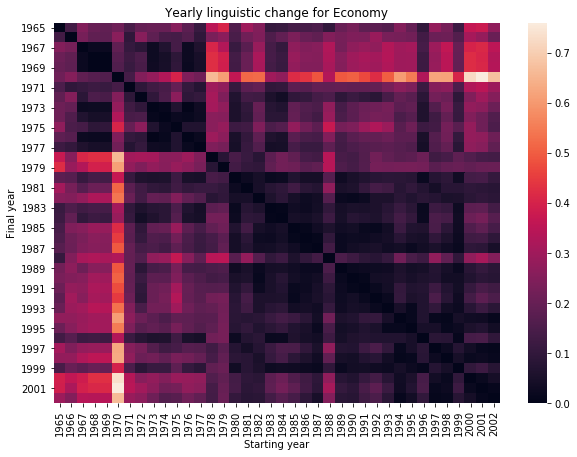

In [7]:
targetWord = '经济'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for {}".format('Economy'))
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/economic_1year.png')
plt.show()

政治


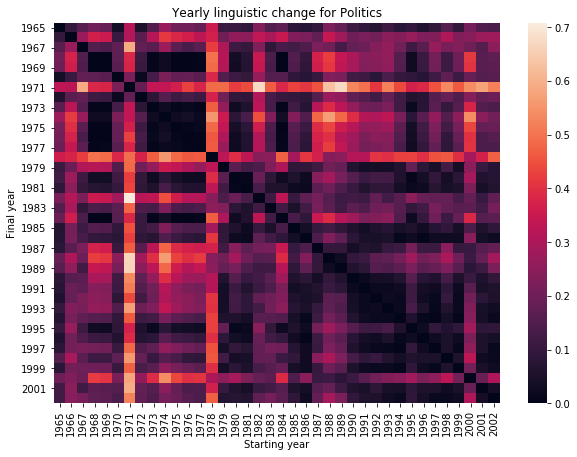

In [8]:
targetWord = '政治'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for {}".format('Politics'))
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/political_1year.png')
plt.show()

社会主义


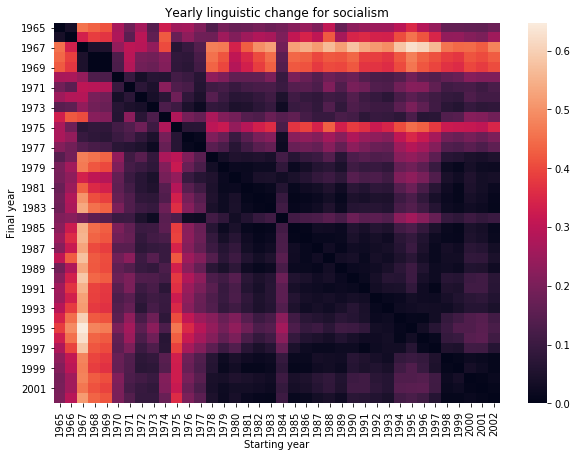

In [9]:
targetWord = '社会主义'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for {}".format('socialism'))
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/socialism_1year.png')
plt.show()

资本主义


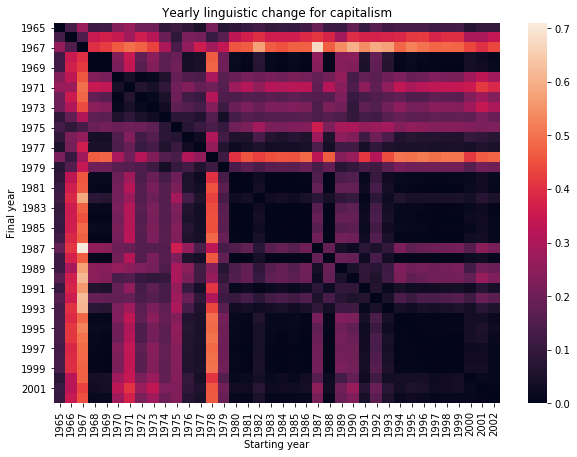

In [10]:
targetWord = '资本主义'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for {}".format('capitalism'))
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/capitalism_1year.png')
plt.show()

## Economic Words Dynamics - convergence path

In [12]:
embeddings_raw = {}
for year in cats: 
    embeddings_raw[year] = Word2Vec.load(f'../models/Word2Vec&Doc2Vec/filtered_corpus/rmrb_{year}_W2V')

In [13]:
%%time
from functools import reduce
common_words = reduce((lambda x, y: x & y), [embeddings_raw[year].wv.vocab.keys() for year in cats])

Wall time: 32.9 ms


In [14]:
%%time
from functools import reduce
common_econ_words = reduce((lambda x, y: x & y), 
                           [{token[0] for token in embeddings_raw[year].wv.most_similar('经济', topn=3500)} for year in cats])

Wall time: 814 ms


In [15]:
%%time
from functools import reduce
common_poli_words = reduce((lambda x, y: x & y), 
                           [{token[0] for token in embeddings_raw[year].wv.most_similar('政治', topn=3500)} for year in cats])

Wall time: 310 ms


In [16]:
def semantic_vectors_dynamics_aligned_previous(cats, common_words, embeddings_aligned): 
    dist_values = []
    cur_year_wvs_year = []
    pre_year_wvs_year = []
    for year in cats: 
        if year == cats[0]: 
            dist_values.append(None)
        else: 
            cur_year_wvs = []
            pre_year_wvs = []
            for word in common_words: 
                cur_year_wvs.append(np.array(embeddings_aligned[year - 1][year - cats[0] + 1].wv[word]))
                pre_year_wvs.append(np.array(embeddings_aligned[year - 1][0].wv[word]))
            cur_year_wvs_year.append(np.array(cur_year_wvs))
            pre_year_wvs_year.append(np.array(pre_year_wvs))
    # calculate Euclidean distances of each year and the previous year. 
    for ind, (cur_year_wvs, pre_year_wvs) in enumerate(zip(cur_year_wvs_year, pre_year_wvs_year)): 
        dist_values.append(
            np.linalg.norm(
                cur_year_wvs.reshape(-1) - pre_year_wvs.reshape(-1)
            )
        )
    return dist_values

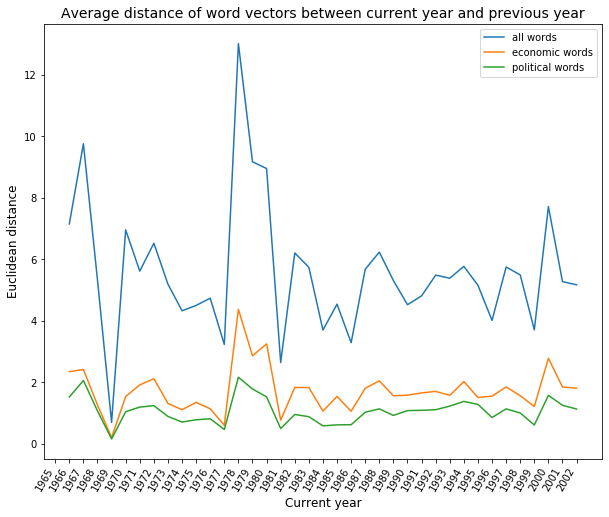

In [17]:
# relative change compared with previous year
dist_values_aligned_pre = semantic_vectors_dynamics_aligned_previous(cats, common_words, embeddings_aligned)
dist_values_aligned_pre_econ = semantic_vectors_dynamics_aligned_previous(cats, common_econ_words, embeddings_aligned)
dist_values_aligned_pre_poli = semantic_vectors_dynamics_aligned_previous(cats, common_poli_words, embeddings_aligned)
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre, label='all words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre_econ, label='economic words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_pre_poli, label='political words')
ax.set_title('Average distance of word vectors between current year and previous year', fontsize=14)
ax.set_xlabel('Current year', fontsize=12)
ax.set_ylabel('Euclidean distance', fontsize=12)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/converge_path_preyear.png')
plt.show()

In [18]:
def semantic_vectors_dynamics_aligned_specific(year, common_words, embeddings_aligned): 
    base_year = year
    distribution_matrix_aligned_to_specific = []
    for aligned_model in embeddings_aligned[base_year][1:]:
        distribution_vector_aligned_to_specific = []
        for word in common_words: 
            distribution_vector_aligned_to_specific.append(aligned_model.wv[word])
        distribution_matrix_aligned_to_specific.append(np.array(distribution_vector_aligned_to_specific))

    # calculate Euclidean distances of each year and the specific year. 
    dist_values = []
    for vector in distribution_matrix_aligned_to_specific: 
        dist_values.append(
            np.linalg.norm(
                vector.reshape(-1) - distribution_matrix_aligned_to_specific[year - 1965].reshape(-1)
            )
        )
    return dist_values

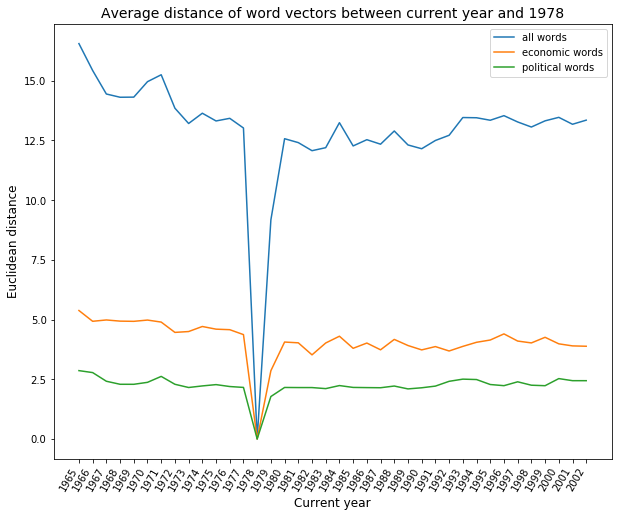

In [19]:
# relative change compared with 1978
dist_values_aligned_1978 = semantic_vectors_dynamics_aligned_specific(1978, common_words, embeddings_aligned)
dist_values_aligned_1978_econ = semantic_vectors_dynamics_aligned_specific(1978, common_econ_words, embeddings_aligned)
dist_values_aligned_1978_poli = semantic_vectors_dynamics_aligned_specific(1978, common_poli_words, embeddings_aligned)
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978, label='all words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978_econ, label='economic words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978_poli, label='political words')
ax.set_title('Average distance of word vectors between current year and 1978', fontsize=14)
ax.set_xlabel('Current year', fontsize=12)
ax.set_ylabel('Euclidean distance', fontsize=12)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/converge_path_1978.png')
plt.show()

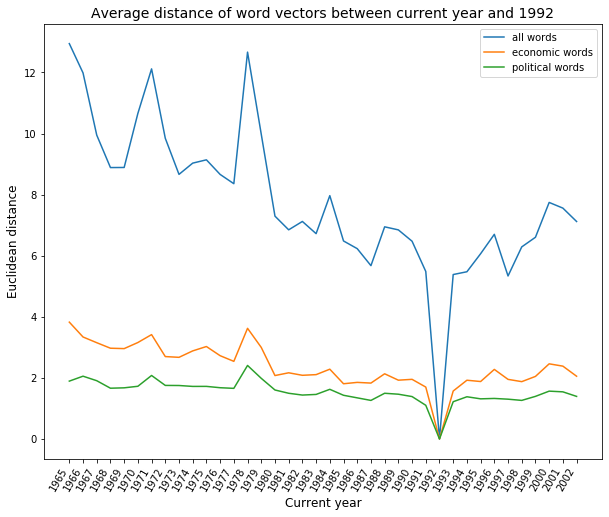

In [20]:
# relative change compared with 1992
dist_values_aligned_1978 = semantic_vectors_dynamics_aligned_specific(1992, common_words, embeddings_aligned)
dist_values_aligned_1978_econ = semantic_vectors_dynamics_aligned_specific(1992, common_econ_words, embeddings_aligned)
dist_values_aligned_1978_poli = semantic_vectors_dynamics_aligned_specific(1992, common_poli_words, embeddings_aligned)
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978, label='all words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978_econ, label='economic words')
ax.plot([str(cat) for cat in cats], dist_values_aligned_1978_poli, label='political words')
ax.set_title('Average distance of word vectors between current year and 1992', fontsize=14)
ax.set_xlabel('Current year', fontsize=12)
ax.set_ylabel('Euclidean distance', fontsize=12)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=60, horizontalalignment='right')
plt.savefig('../pictures/dynamic_word2vec/absolute_aligned/converge_path_1992.png')
plt.show()